# Ground-roll attenuation model with attention

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Hyperparameters estimation](#Hyperparameters-estimation)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Index field records:

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, V, B
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot)

%env CUDA_VISIBLE_DEVICES=3

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

env: CUDA_VISIBLE_DEVICES=3


,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [4]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = Dataset(tindex, SeismicBatch)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model architecture:

In [5]:
class UnetAtt(UNet):
    def body(self, inputs, *args, **kwargs):
        main_config = self.config['main_config']
        attn_config = self.config['attn_config']
        main = super().body(inputs, name='main', **main_config)
        att = super().body(inputs, name='attention', **attn_config)
        return main, att, inputs
        
    def head(self, inputs, *args, **kwargs):
        main, att, raw = inputs
        
        att = conv_block(att, layout='ca', kernel_size=3, filters=1, units=1, activation=tf.nn.sigmoid, name='head_att')
        main = conv_block(main, layout='c', filters=1, units=1, name='head_main')
        
        att_sum = tf.reduce_sum(att, axis=1, keepdims=True)
        sigm_x = tf.fill(tf.shape(att), 0.0)
        arange = tf.range(0, tf.cast(tf.shape(sigm_x)[1], 'float'), dtype='float')
        arange = tf.expand_dims(arange, axis=-1)
        sigm_x = sigm_x - arange + att_sum
        attention_sigmoid = tf.sigmoid(sigm_x)
        self.store_to_attr("attention_sigmoid", attention_sigmoid)
        out_lift = raw * attention_sigmoid + main * (1 - attention_sigmoid)
        self.store_to_attr("out_lift", out_lift)
        return tf.stack([out_lift, attention_sigmoid], axis=0)

Define the model config and loss function:

In [6]:
def my_loss(targets, predictions, *args, **kwargs):
    out_lift = predictions[0]
    attention_sigmoid = predictions[1]
    loss = (tf.losses.absolute_difference(targets, out_lift) +
            0.05 * tf.reduce_mean(1 - attention_sigmoid))
    tf.losses.add_loss(loss)
    return loss

model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)}, 
                   lift={'name': 'targets', 'shape': (3000, 1)}),
    'loss': my_loss,  
    'main_config': {'filters': 2 * np.array([8, 16, 32, 64, 128]),
                    'data_format': "channels_last",
                    'encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
                    'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
                    'decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
                    'upsample': dict(layout='tad', kernel_size=7, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),},
    'attn_config': {'filters': [8, 16, 32, 64],
                    'data_format': "channels_last",
                    'encoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
                    'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
                    'decoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
                    'upsample': dict(layout='tad', kernel_size=3, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),},
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 1.

Define a train pipeline:

In [7]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': np.expand_dims(np.vstack(batch.raw), -1),
                          'lift': np.expand_dims(np.vstack(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .init_model('dynamic', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss', init_on_each_run=list)
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss', save_to=V('loss', 'a'))
                 )

train_pipeline = train_pipeline << train_set

Run model training:

In [8]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=1, drop_last=True,
                                    shuffle=True, bar=True)

  0%|          | 0/540 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|█████████▉| 539/540 [01:53<00:00,  5.12it/s]


Plot loss function decay:

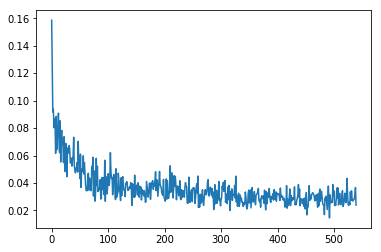

In [9]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.show()

## Inference

Inference pipeline:

In [10]:
fetches=['out_lift', 'attention_sigmoid']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', init_on_each_run=list())
                 .init_variable('raw', init_on_each_run=list())
                 .init_variable('lift', init_on_each_run=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))

In [11]:
i = 39
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

test_pipeline = test_pipeline << test_set

In [12]:
test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:03<00:01,  1.03s/it]


In [13]:
np.vstack(test_pipeline.get_variable('raw')[0]).shape

(1000, 3000)

In [14]:
raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))

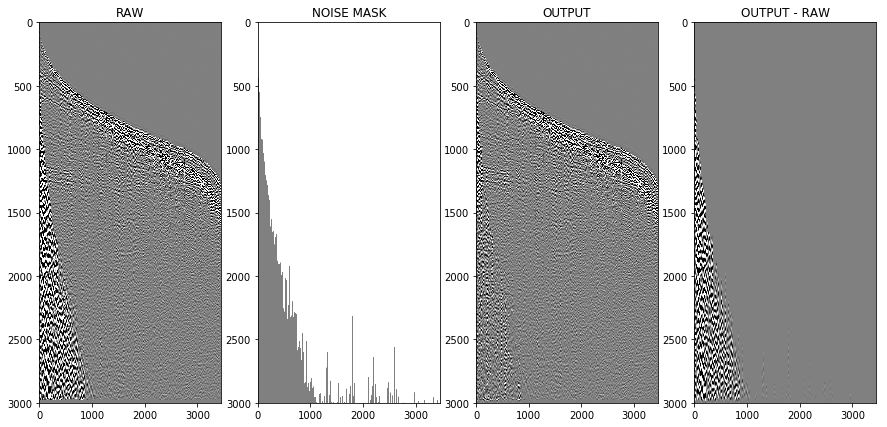

In [17]:
cv = 0.5
seismic_plot([raw, att, out, out - raw],
             figsize=(15, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW'],
             cmap='gray', vmin=-cv, vmax=cv)

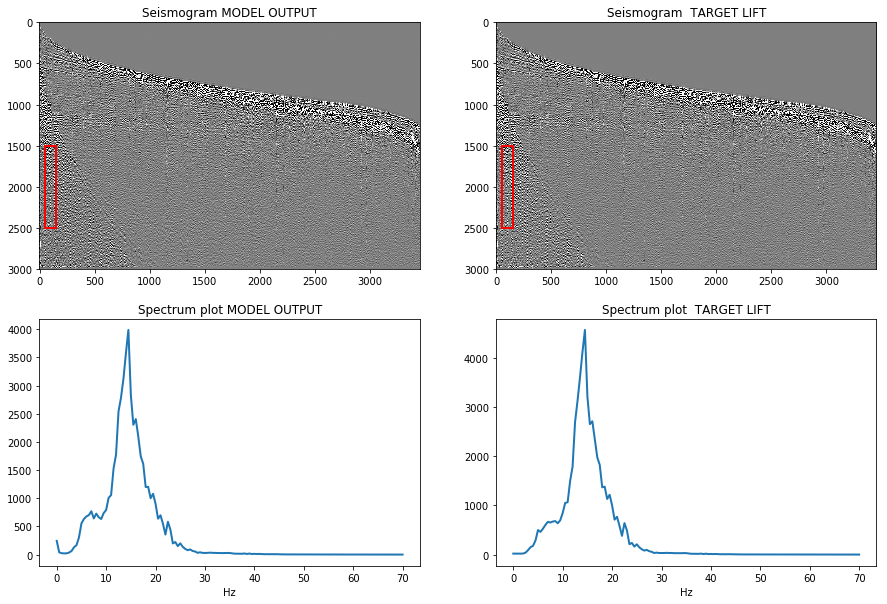

In [19]:
spectrum_plot([out, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['MODEL OUTPUT', ' TARGET LIFT'])

## Criticism

The model produces artefact attantion mask outside the ground-roll area. 

## Conclusion

TBD

## Suggestions for improvements

TBD